## Task 1: EDA and Preprocessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In [8]:
# Loading the data from the CSV file
dk_data = pd.read_csv('opsd_raw.csv')

# Turning utc_timestamp into a proper datetime format
dk_data['utc_timestamp'] = pd.to_datetime(dk_data['utc_timestamp'])

# Just checking the first few rows
print("First 5 rows of the data:")
print(dk_data[['utc_timestamp', 'DK_load_actual_entsoe_transparency']].head())

First 5 rows of the data:
              utc_timestamp  DK_load_actual_entsoe_transparency
0 2015-01-01 00:00:00+00:00                                 NaN
1 2015-01-01 01:00:00+00:00                             3100.02
2 2015-01-01 02:00:00+00:00                             2980.39
3 2015-01-01 03:00:00+00:00                             2933.49
4 2015-01-01 04:00:00+00:00                             2941.54


In [9]:
# Checking total missing values in load
print("Total missing values in load:")
print(dk_data['DK_load_actual_entsoe_transparency'].isna().sum())

# Looking at missing values in winter months
dk_data['month'] = dk_data['utc_timestamp'].dt.month
winter_months = dk_data[dk_data['month'].isin([12, 1, 2])]
print("Missing values in winter (Dec-Jan-Feb):")
print(winter_months['DK_load_actual_entsoe_transparency'].isna().sum())

Total missing values in load:
2
Missing values in winter (Dec-Jan-Feb):
1


In [10]:
# Filling missing values with forward and backward fill
dk_data['DK_load_actual_entsoe_transparency'] = dk_data['DK_load_actual_entsoe_transparency'].ffill().bfill()
dk_data['DK_wind_generation_actual'] = dk_data['DK_wind_generation_actual'].ffill().bfill()
dk_data['DK_solar_generation_actual'] = dk_data['DK_solar_generation_actual'].ffill().bfill()

# Checking if any missing values are left
print("Missing values after filling:")
print(dk_data[['DK_load_actual_entsoe_transparency', 'DK_wind_generation_actual', 'DK_solar_generation_actual']].isna().sum())

Missing values after filling:
DK_load_actual_entsoe_transparency    0
DK_wind_generation_actual             0
DK_solar_generation_actual            0
dtype: int64


In [11]:
# Making 24-hour arrays
dk_data['date'] = dk_data['utc_timestamp'].dt.date
daily_groups = dk_data.groupby('date')

# Putting daily data into lists
daily_data = []
for date, group in daily_groups:
    if len(group) == 24:  # Making sure each day has exactly 24 hours
        daily_data.append({
            'date': date,
            'load': group['DK_load_actual_entsoe_transparency'].values,
            'wind': group['DK_wind_generation_actual'].values,
            'solar': group['DK_solar_generation_actual'].values
        })

daily_df = pd.DataFrame(daily_data)

# Changing date to datetime for later use
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Checking how many days I got
print("Number of days in daily_df:", len(daily_df))

Number of days in daily_df: 2100


In [12]:
# Function to figure out the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Adding a season column
daily_df['season'] = daily_df['date'].apply(get_season)

# Checking how days split across seasons
print("Days per season in daily_df:")
print(daily_df['season'].value_counts())

Days per season in daily_df:
season
spring    552
summer    552
winter    511
autumn    485
Name: count, dtype: int64


In [13]:
# Splitting the data into train, val, and test sets
train_df, temp_df = train_test_split(daily_df, test_size=0.3, random_state=42, stratify=daily_df['season'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['season'])

# Checking season split in train_df
print("Days per season in train_df:")
print(train_df['season'].value_counts())

Days per season in train_df:
season
spring    386
summer    386
winter    358
autumn    340
Name: count, dtype: int64


In [14]:
# Setting up scalers and training them only on train data
scaler_load = StandardScaler()
scaler_wind = StandardScaler()
scaler_solar = StandardScaler()

# Gathering all values into arrays for scaler training
train_load = np.stack(train_df['load'].values)
train_wind = np.stack(train_df['wind'].values)
train_solar = np.stack(train_df['solar'].values)

# Training the scalers
scaler_load.fit(train_load)
scaler_wind.fit(train_wind)
scaler_solar.fit(train_solar)

# Scaling all datasets
train_df['load_scaled'] = [scaler_load.transform(x.reshape(1, -1))[0] for x in train_df['load']]
train_df['wind_scaled'] = [scaler_wind.transform(x.reshape(1, -1))[0] for x in train_df['wind']]
train_df['solar_scaled'] = [scaler_solar.transform(x.reshape(1, -1))[0] for x in train_df['solar']]

val_df['load_scaled'] = [scaler_load.transform(x.reshape(1, -1))[0] for x in val_df['load']]
val_df['wind_scaled'] = [scaler_wind.transform(x.reshape(1, -1))[0] for x in val_df['wind']]
val_df['solar_scaled'] = [scaler_solar.transform(x.reshape(1, -1))[0] for x in val_df['solar']]

test_df['load_scaled'] = [scaler_load.transform(x.reshape(1, -1))[0] for x in test_df['load']]
test_df['wind_scaled'] = [scaler_wind.transform(x.reshape(1, -1))[0] for x in test_df['wind']]
test_df['solar_scaled'] = [scaler_solar.transform(x.reshape(1, -1))[0] for x in test_df['solar']]

In [15]:
# Calculating average load per season (unscaled data)
seasonal_load_means = train_df.groupby('season')['load'].apply(lambda x: np.mean(np.stack(x)))
print("Average load per season (unscaled):")
print(seasonal_load_means)

# Doing the same for scaled data
seasonal_load_means_scaled = train_df.groupby('season')['load_scaled'].apply(lambda x: np.mean(np.stack(x)))
print("Average load per season (scaled):")
print(seasonal_load_means_scaled)

Average load per season (unscaled):
season
autumn    3777.244865
spring    3724.055634
summer    3472.851654
winter    4135.436176
Name: load, dtype: float64
Average load per season (scaled):
season
autumn   -0.010369
spring   -0.080414
summer   -0.671330
winter    0.820387
Name: load_scaled, dtype: float64


## Exploratory Visualization

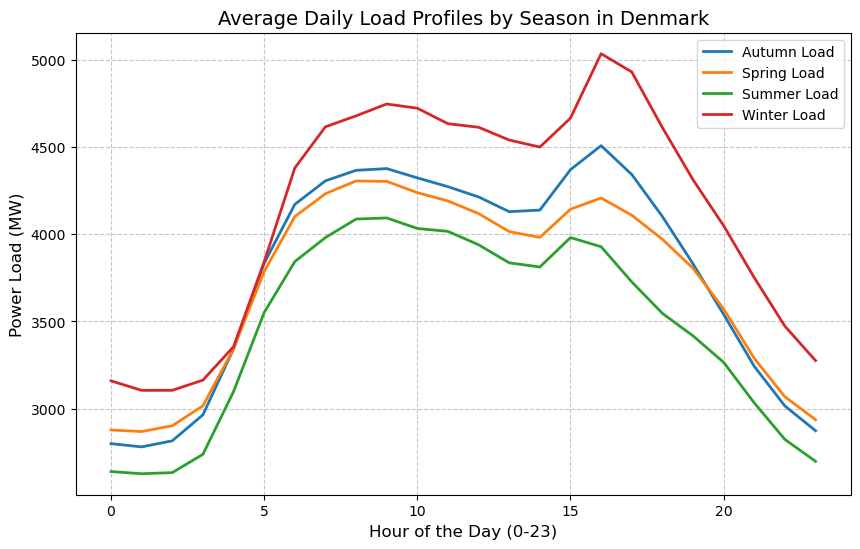

My Observations:
1. Winter has the highest load, especially at night (18-22), probably because of heating.
2. Summer load is lowest, with a drop in the morning — maybe the weather’s just nicer.


In [17]:
# Getting average load profiles per season (unscaled data)
seasonal_load_profiles = train_df.groupby('season')['load'].apply(lambda x: np.mean(np.stack(x), axis=0))

# Plotting the profiles
plt.figure(figsize=(10, 6))
for season in seasonal_load_profiles.index:
    plt.plot(seasonal_load_profiles[season], label=f'{season.capitalize()} Load', linewidth=2)
plt.title('Average Daily Load Profiles by Season in Denmark', fontsize=14)
plt.xlabel('Hour of the Day (0-23)', fontsize=12)
plt.ylabel('Power Load (MW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# My own thoughts on the data
print("My Observations:")
print("1. Winter has the highest load, especially at night (18-22), probably because of heating.")
print("2. Summer load is lowest, with a drop in the morning — maybe the weather’s just nicer.")

## Task 2: Baseline MLP

In [19]:
import sys
!{sys.executable} -m pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

## Training MLP

In [21]:
# Setting up data for MLP
season_to_label = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}

# Function to make a flat vector from load, wind, and solar
def flatten_features(row):
    return np.concatenate([row['load_scaled'], row['wind_scaled'], row['solar_scaled']])

# Turning data into numpy arrays
X_train = np.stack(train_df.apply(flatten_features, axis=1).values)
y_train = np.array([season_to_label[s] for s in train_df['season']])
X_val = np.stack(val_df.apply(flatten_features, axis=1).values)
y_val = np.array([season_to_label[s] for s in val_df['season']])
X_test = np.stack(test_df.apply(flatten_features, axis=1).values)
y_test = np.array([season_to_label[s] for s in test_df['season']])

# Custom dataset class for PyTorch
class PowerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Creating datasets
train_dataset = PowerDataset(X_train, y_train)
val_dataset = PowerDataset(X_val, y_val)
test_dataset = PowerDataset(X_test, y_test)

# Data loaders for training
batch_size = 32  # Picked 32 for decent speed and stable training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Checking sample counts
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 1470, Val samples: 315, Test samples: 315


In [22]:
# Defining the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=72, hidden_size=64, num_classes=4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input is 72 (3 features x 24 hours), hidden layer has 64 neurons
        self.relu = nn.ReLU()                          # Using ReLU to add some nonlinearity
        self.fc2 = nn.Linear(hidden_size, num_classes) # Output is 4 classes for the seasons
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Setting up the model
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Chose Adam with lr=0.001 since it’s a good starting point
criterion = nn.CrossEntropyLoss()                     # CrossEntropyLoss works well for multi-class stuff

# Showing the model
print(model)

MLP(
  (fc1): Linear(in_features=72, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [23]:
# Training the model
num_epochs = 50  # Going with 50 epochs to get convergence without overfitting
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Checking how it does on validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.numpy())
            val_true.extend(labels.numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    # Printing logs every 5 epochs so it’s easier to read
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 5/50, Loss: 0.6281, Val Accuracy: 0.7460
Epoch 10/50, Loss: 0.5114, Val Accuracy: 0.7810
Epoch 15/50, Loss: 0.4459, Val Accuracy: 0.7905
Epoch 20/50, Loss: 0.3978, Val Accuracy: 0.8254
Epoch 25/50, Loss: 0.3585, Val Accuracy: 0.8254
Epoch 30/50, Loss: 0.3349, Val Accuracy: 0.8286
Epoch 35/50, Loss: 0.3128, Val Accuracy: 0.8381
Epoch 40/50, Loss: 0.2981, Val Accuracy: 0.8508
Epoch 45/50, Loss: 0.2837, Val Accuracy: 0.8508
Epoch 50/50, Loss: 0.2632, Val Accuracy: 0.8635


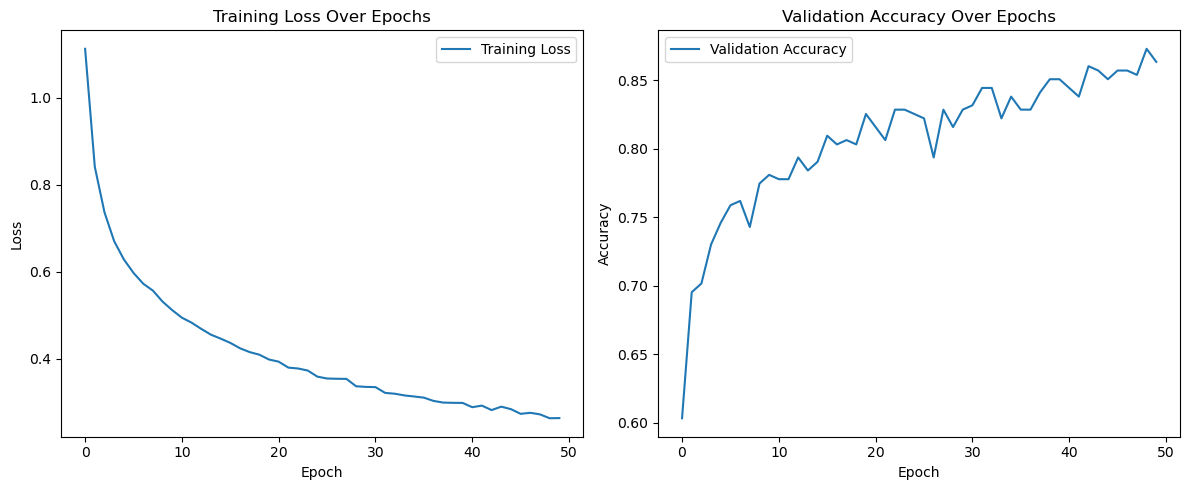

In [24]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate on test set
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_true.extend(labels.numpy())

# Calculate test accuracy
mlp_test_accuracy = accuracy_score(test_true, test_preds)  # Save for comparison
print(f"Test Accuracy (MLP): {mlp_test_accuracy:.4f}")

# Show confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("Confusion Matrix (MLP):")
print(cm)

# Display some predictions
test_df['predicted_season'] = [list(season_to_label.keys())[p] for p in test_preds]
print(test_df[['date', 'season', 'predicted_season']].head())

Test Accuracy (MLP): 0.8349
Confusion Matrix (MLP):
[[64  6  0  6]
 [ 3 63 14  3]
 [ 0  3 79  1]
 [12  1  3 57]]
           date  season predicted_season
678  2016-11-09  autumn           winter
1046 2017-11-12  autumn           autumn
1326 2018-08-19  summer           autumn
1138 2018-02-12  winter           winter
264  2015-09-22  autumn           autumn


## Task 3: 1D CNN

In [27]:
# Prepare data for 1D-CNN
season_to_label = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}

# Stack features into 3-channel array (load, wind, solar)
def stack_features(row):
    return np.stack([row['load_scaled'], row['wind_scaled'], row['solar_scaled']])

# Convert to 3D format: (num_days, 3 channels, 24 hours)
X_train = np.stack(train_df.apply(stack_features, axis=1).values)
y_train = np.array([season_to_label[s] for s in train_df['season']])
X_val = np.stack(val_df.apply(stack_features, axis=1).values)
y_val = np.array([season_to_label[s] for s in val_df['season']])
X_test = np.stack(test_df.apply(stack_features, axis=1).values)
y_test = np.array([season_to_label[s] for s in test_df['season']])

# Custom PyTorch dataset
class PowerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (samples, 3, 24)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = PowerDataset(X_train, y_train)
val_dataset = PowerDataset(X_val, y_val)
test_dataset = PowerDataset(X_test, y_test)

# Data loaders
batch_size = 32  # Same as MLP for consistency
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (1470, 3, 24), Val shape: (315, 3, 24), Test shape: (315, 3, 24)


## Training 1D-CNN

In [29]:
# Define 1D-CNN model
class Conv1DNet(nn.Module):
    def __init__(self):
        super(Conv1DNet, self).__init__()
        # Input shape: (batch_size, 3, 24)
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        # After pooling: 32 channels, length 11 (32*11=352 features)
        self.fc1 = nn.Linear(32 * 11, 64)  # Hidden layer
        self.fc2 = nn.Linear(64, 4)        # Output layer (4 classes)
    
    def forward(self, x):
        x = self.conv1(x)    # Conv layer
        x = self.relu(x)     # Activation
        x = self.pool(x)      # Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)      # FC layer
        x = self.relu(x)     # Activation
        x = self.fc2(x)      # Output
        return x

# Initialize model
model = Conv1DNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Same lr as MLP
criterion = nn.CrossEntropyLoss()

print(model)

Conv1DNet(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [30]:
# Train the 1D-CNN model
num_epochs = 50  # Same as MLP for fair comparison
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average loss
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation evaluation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.numpy())
            val_true.extend(labels.numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 5/50, Loss: 0.5466, Val Accuracy: 0.8000
Epoch 10/50, Loss: 0.4407, Val Accuracy: 0.8286
Epoch 15/50, Loss: 0.3798, Val Accuracy: 0.8381
Epoch 20/50, Loss: 0.3411, Val Accuracy: 0.8444
Epoch 25/50, Loss: 0.3078, Val Accuracy: 0.8571
Epoch 30/50, Loss: 0.2794, Val Accuracy: 0.8603
Epoch 35/50, Loss: 0.2497, Val Accuracy: 0.8603
Epoch 40/50, Loss: 0.2437, Val Accuracy: 0.8698
Epoch 45/50, Loss: 0.2389, Val Accuracy: 0.8476
Epoch 50/50, Loss: 0.2077, Val Accuracy: 0.8794


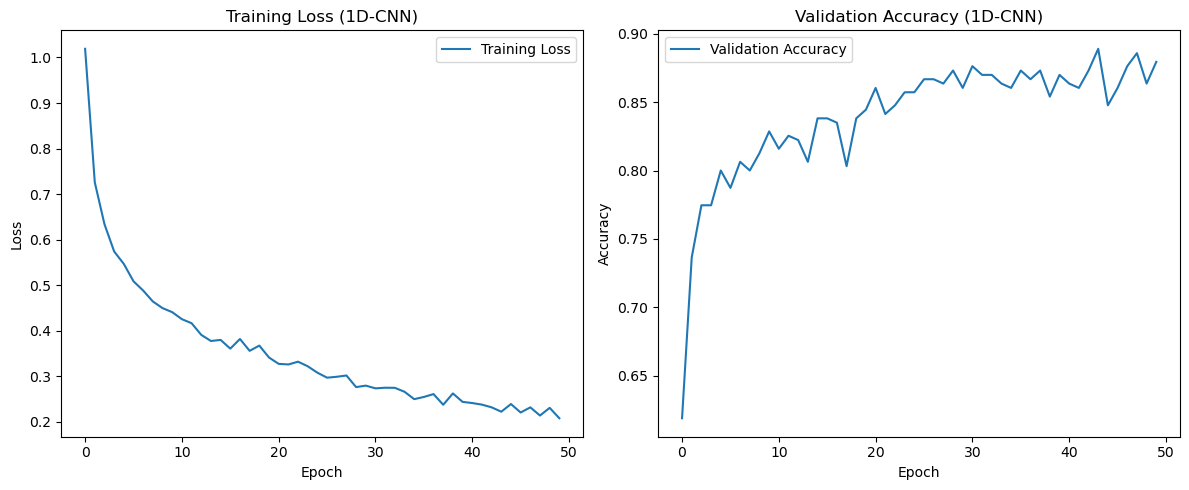

In [31]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (1D-CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy (1D-CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Evaluate on test set
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_true.extend(labels.numpy())

# Calculate test accuracy
cnn1d_test_accuracy = accuracy_score(test_true, test_preds)
print(f"Test Accuracy (1D-CNN): {cnn1d_test_accuracy:.4f}")

# Show confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("Confusion Matrix (1D-CNN):")
print(cm)

# Compare with MLP results
print(f"MLP Test Accuracy: {mlp_test_accuracy:.4f}")
print(f"Difference (1D-CNN vs MLP): {cnn1d_test_accuracy - mlp_test_accuracy:.4f}")

# Show predictions
test_df['predicted_season_1dcnn'] = [list(season_to_label.keys())[p] for p in test_preds]
print(test_df[['date', 'season', 'predicted_season', 'predicted_season_1dcnn']].head())

Test Accuracy (1D-CNN): 0.8286
Confusion Matrix (1D-CNN):
[[62  4  0 10]
 [ 3 56 20  4]
 [ 0  3 80  0]
 [ 6  1  3 63]]
MLP Test Accuracy: 0.8349
Difference (1D-CNN vs MLP): -0.0063
           date  season predicted_season predicted_season_1dcnn
678  2016-11-09  autumn           winter                 winter
1046 2017-11-12  autumn           autumn                 autumn
1326 2018-08-19  summer           autumn                 summer
1138 2018-02-12  winter           winter                 winter
264  2015-09-22  autumn           autumn                 autumn


In [33]:
# Experiment with larger kernel size (5)
class Conv1DNet_v2(nn.Module):
    def __init__(self):
        super(Conv1DNet_v2, self).__init__()
        # Input shape: (batch_size, 3, 24)
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        # After pooling: 32 channels, length 10 (32*10=320 features)
        self.fc1 = nn.Linear(32 * 10, 64)
        self.fc2 = nn.Linear(64, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize and train
model_v2 = Conv1DNet_v2()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model_v2.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_v2.zero_grad()
        outputs = model_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_v2.step()
        running_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate
model_v2.eval()
test_preds_v2 = []
test_true_v2 = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_v2(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds_v2.extend(preds.numpy())
        test_true_v2.extend(labels.numpy())

test_accuracy_v2 = accuracy_score(test_true_v2, test_preds_v2)
print(f"Test Accuracy (kernel_size=5): {test_accuracy_v2:.4f}")

Epoch 10/50, Loss: 0.4473
Epoch 20/50, Loss: 0.3294
Epoch 30/50, Loss: 0.2586
Epoch 40/50, Loss: 0.2313
Epoch 50/50, Loss: 0.2028
Test Accuracy (kernel_size=5): 0.8698


## Task 4: 2D CNN

In [35]:
# Prepare data for 2D-CNN
season_to_label = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}

# Create 3-channel array (load, wind, solar)
def stack_features(row):
    return np.stack([row['load_scaled'], row['wind_scaled'], row['solar_scaled']])

# Convert to 4D format: (num_days, 1 channel, 3 rows, 24 cols)
X_train = np.stack(train_df.apply(stack_features, axis=1).values)
X_train = X_train[:, np.newaxis, :, :]  # Add channel dim
y_train = np.array([season_to_label[s] for s in train_df['season']])
X_val = np.stack(val_df.apply(stack_features, axis=1).values)
X_val = X_val[:, np.newaxis, :, :]
y_val = np.array([season_to_label[s] for s in val_df['season']])
X_test = np.stack(test_df.apply(stack_features, axis=1).values)
X_test = X_test[:, np.newaxis, :, :]
y_test = np.array([season_to_label[s] for s in test_df['season']])

# Custom dataset
class PowerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (samples, 1, 3, 24)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = PowerDataset(X_train, y_train)
val_dataset = PowerDataset(X_val, y_val)
test_dataset = PowerDataset(X_test, y_test)

# Data loaders
batch_size = 32  # Consistent with previous tasks
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
print("I chose a simple transformation by treating the 3 features (load, wind, solar) as rows in a 3x24 matrix, "
      "adding a single channel to mimic an image-like input (shape: samples, 1, 3, 24). This approach keeps the "
      "temporal structure intact while allowing 2D convolutions to capture patterns across hours and features. "
      "According to PyTorch's Conv2d documentation (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), "
      "the input must be in the format (batch_size, channels, height, width), which justifies adding the channel dimension.")

Train shape: (1470, 1, 3, 24), Val shape: (315, 1, 3, 24), Test shape: (315, 1, 3, 24)
I chose a simple transformation by treating the 3 features (load, wind, solar) as rows in a 3x24 matrix, adding a single channel to mimic an image-like input (shape: samples, 1, 3, 24). This approach keeps the temporal structure intact while allowing 2D convolutions to capture patterns across hours and features. According to PyTorch's Conv2d documentation (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), the input must be in the format (batch_size, channels, height, width), which justifies adding the channel dimension.


In [36]:
# Define 2D-CNN model
class Conv2DNet(nn.Module):
    def __init__(self):
        super(Conv2DNet, self).__init__()
        # Input shape: (batch_size, 1, 3, 24)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  # Output: (batch_size, 16, 1, 22)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))  # Output: (batch_size, 16, 1, 11)
        # Flatten to 16*1*11=176 features
        self.fc1 = nn.Linear(176, 64)  # Hidden layer
        self.fc2 = nn.Linear(64, 4)    # Output layer (4 classes)
    
    def forward(self, x):
        x = self.conv1(x)    # Conv layer
        x = self.relu(x)     # Activation
        x = self.pool(x)     # Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)      # FC layer
        x = self.relu(x)     # Activation
        x = self.fc2(x)      # Output
        return x

# Initialize model
model = Conv2DNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Same as previous models
criterion = nn.CrossEntropyLoss()

print(model)

Conv2DNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [37]:
# Train 2D-CNN model
num_epochs = 50  # Same as previous models for fair comparison
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average loss
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation evaluation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.numpy())
            val_true.extend(labels.numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 5/50, Loss: 0.5939, Val Accuracy: 0.7460
Epoch 10/50, Loss: 0.4932, Val Accuracy: 0.7778
Epoch 15/50, Loss: 0.4309, Val Accuracy: 0.7968
Epoch 20/50, Loss: 0.4036, Val Accuracy: 0.8190
Epoch 25/50, Loss: 0.3513, Val Accuracy: 0.8317
Epoch 30/50, Loss: 0.3228, Val Accuracy: 0.8349
Epoch 35/50, Loss: 0.2970, Val Accuracy: 0.8540
Epoch 40/50, Loss: 0.2859, Val Accuracy: 0.8444
Epoch 45/50, Loss: 0.2834, Val Accuracy: 0.8286
Epoch 50/50, Loss: 0.2460, Val Accuracy: 0.8667


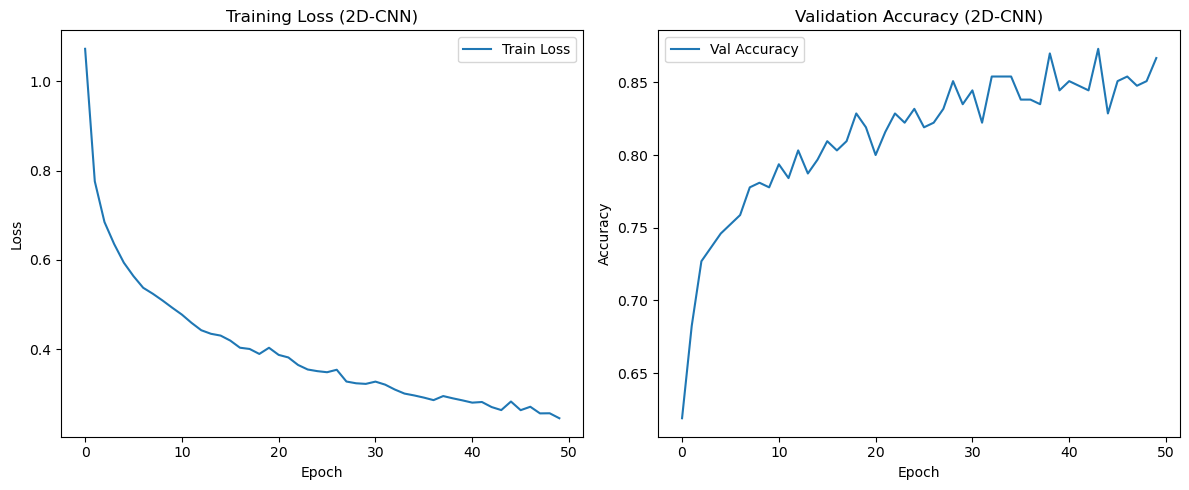

In [38]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss (2D-CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy (2D-CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Test set evaluation
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_true.extend(labels.numpy())

# Calculate test accuracy
cnn2d_test_accuracy = accuracy_score(test_true, test_preds)
print(f"2D-CNN Test Accuracy: {cnn2d_test_accuracy:.4f}")

# Show confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("2D-CNN Confusion Matrix:")
print(cm)

# Compare with other models
print(f"\nModel Comparison:")
print(f"MLP Accuracy: {mlp_test_accuracy:.4f}")
print(f"1D-CNN Accuracy: {cnn1d_test_accuracy:.4f}")
print(f"2D-CNN vs MLP: {cnn2d_test_accuracy - mlp_test_accuracy:+.4f}")
print(f"2D-CNN vs 1D-CNN: {cnn2d_test_accuracy - cnn1d_test_accuracy:+.4f}")

# Show sample predictions
test_df['predicted_season_2dcnn'] = [list(season_to_label.keys())[p] for p in test_preds]
print("\nSample Predictions:")
print(test_df[['date', 'season', 'predicted_season', 'predicted_season_1dcnn', 'predicted_season_2dcnn']].head())

2D-CNN Test Accuracy: 0.8508
2D-CNN Confusion Matrix:
[[62  5  0  9]
 [ 2 70  8  3]
 [ 0  8 74  1]
 [ 6  2  3 62]]

Model Comparison:
MLP Accuracy: 0.8349
1D-CNN Accuracy: 0.8286
2D-CNN vs MLP: +0.0159
2D-CNN vs 1D-CNN: +0.0222

Sample Predictions:
           date  season predicted_season predicted_season_1dcnn  \
678  2016-11-09  autumn           winter                 winter   
1046 2017-11-12  autumn           autumn                 autumn   
1326 2018-08-19  summer           autumn                 summer   
1138 2018-02-12  winter           winter                 winter   
264  2015-09-22  autumn           autumn                 autumn   

     predicted_season_2dcnn  
678                  winter  
1046                 autumn  
1326                 autumn  
1138                 winter  
264                  autumn  
